<h1>Classification of Term Deposits in Bank Marketing Dataset</h1>

<h2>Introduction</h2>
Our chosen dataset, the “bank-additional-full.csv” spreadsheet, documents the marketing efforts of a Portuguese banking institution. 21 variables are measured, with the classification variable being whether or not a client will subscribe to a term deposit. A term deposit is a fixed-term investment that contains the deposit of funds into an account at a financial institution. This data was originally produced by researchers at the University Institute of Lisbon for a report highlighting a data-driven approach to predict the successfulness of bank telemarketing.

This dataset features attributes regarding demographics (age, job, marital status), economic and educational situation (level of education, possession of a housing loan), and historical information’s relationship to the banking institution (last month of contact, outcome from previous marketing campaign). 

Our project will answer the question; given a new client (a new row in the table), can we predict if the client will subscribe to a term deposit?

<h2>Exploratory Data Analysis</h2>

In [11]:
# SETUP CODE
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  emp.var.rate = col_double(),
  cons.price.idx = col_double(),
  cons.conf.idx = col_double(),
  euribor3m = col_double(),
  nr.employed = col_double()
)

See spec(...) for full column specifications.



age job         marital education           default housing loan month
1     56  housemaid   married basic.4y            no      no      no   may  
2     37  services    married high.school         no      yes     no   may  
3     40  admin.      married basic.6y            no      no      no   may  
4     56  services    married high.school         no      no      yes  may  
5     45  services    married basic.9y            unknown no      no   may  
⋮     ⋮   ⋮           ⋮       ⋮                   ⋮       ⋮       ⋮    ⋮    
30887 73  retired     married professional.course no      yes     no   nov  
30888 46  blue-collar married professional.course no      no      no   nov  
30889 56  retired     married university.degree   no      yes     no   nov  
30890 44  technician  married professional.course no      no      no   nov  
30891 74  retired     married professional.course no      yes     no   nov  
      day_of_week campaign y  
1     mon         1        no 
2     mon         1        no 
3     mon         1        no 
4     mon         1        no 
5     mon         1        no 
⋮     ⋮           ⋮        ⋮  
30887 fri         1        yes
30888 fri         1        no 
30889 fri         2        no 
30890 fri         1        yes
30891 fri         3        no

min_age max_age mean_age
1 17      98      40.03108

`summarise()` ungrouping output (override with `.groups` argument)



y   min_age max_age mean_age
1 no  17      95      39.93003
2 yes 17      98      40.82701

`summarise()` regrouping output by 'job' (override with `.groups` argument)



job          y   n   
1  admin.       no  6792
2  admin.       yes  999
3  blue-collar  no  6473
4  blue-collar  yes  473
5  entrepreneur no  1000
⋮  ⋮            ⋮   ⋮   
20 technician   yes 553 
21 unemployed   no  621 
22 unemployed   yes  99 
23 unknown      no  211 
24 unknown      yes  29

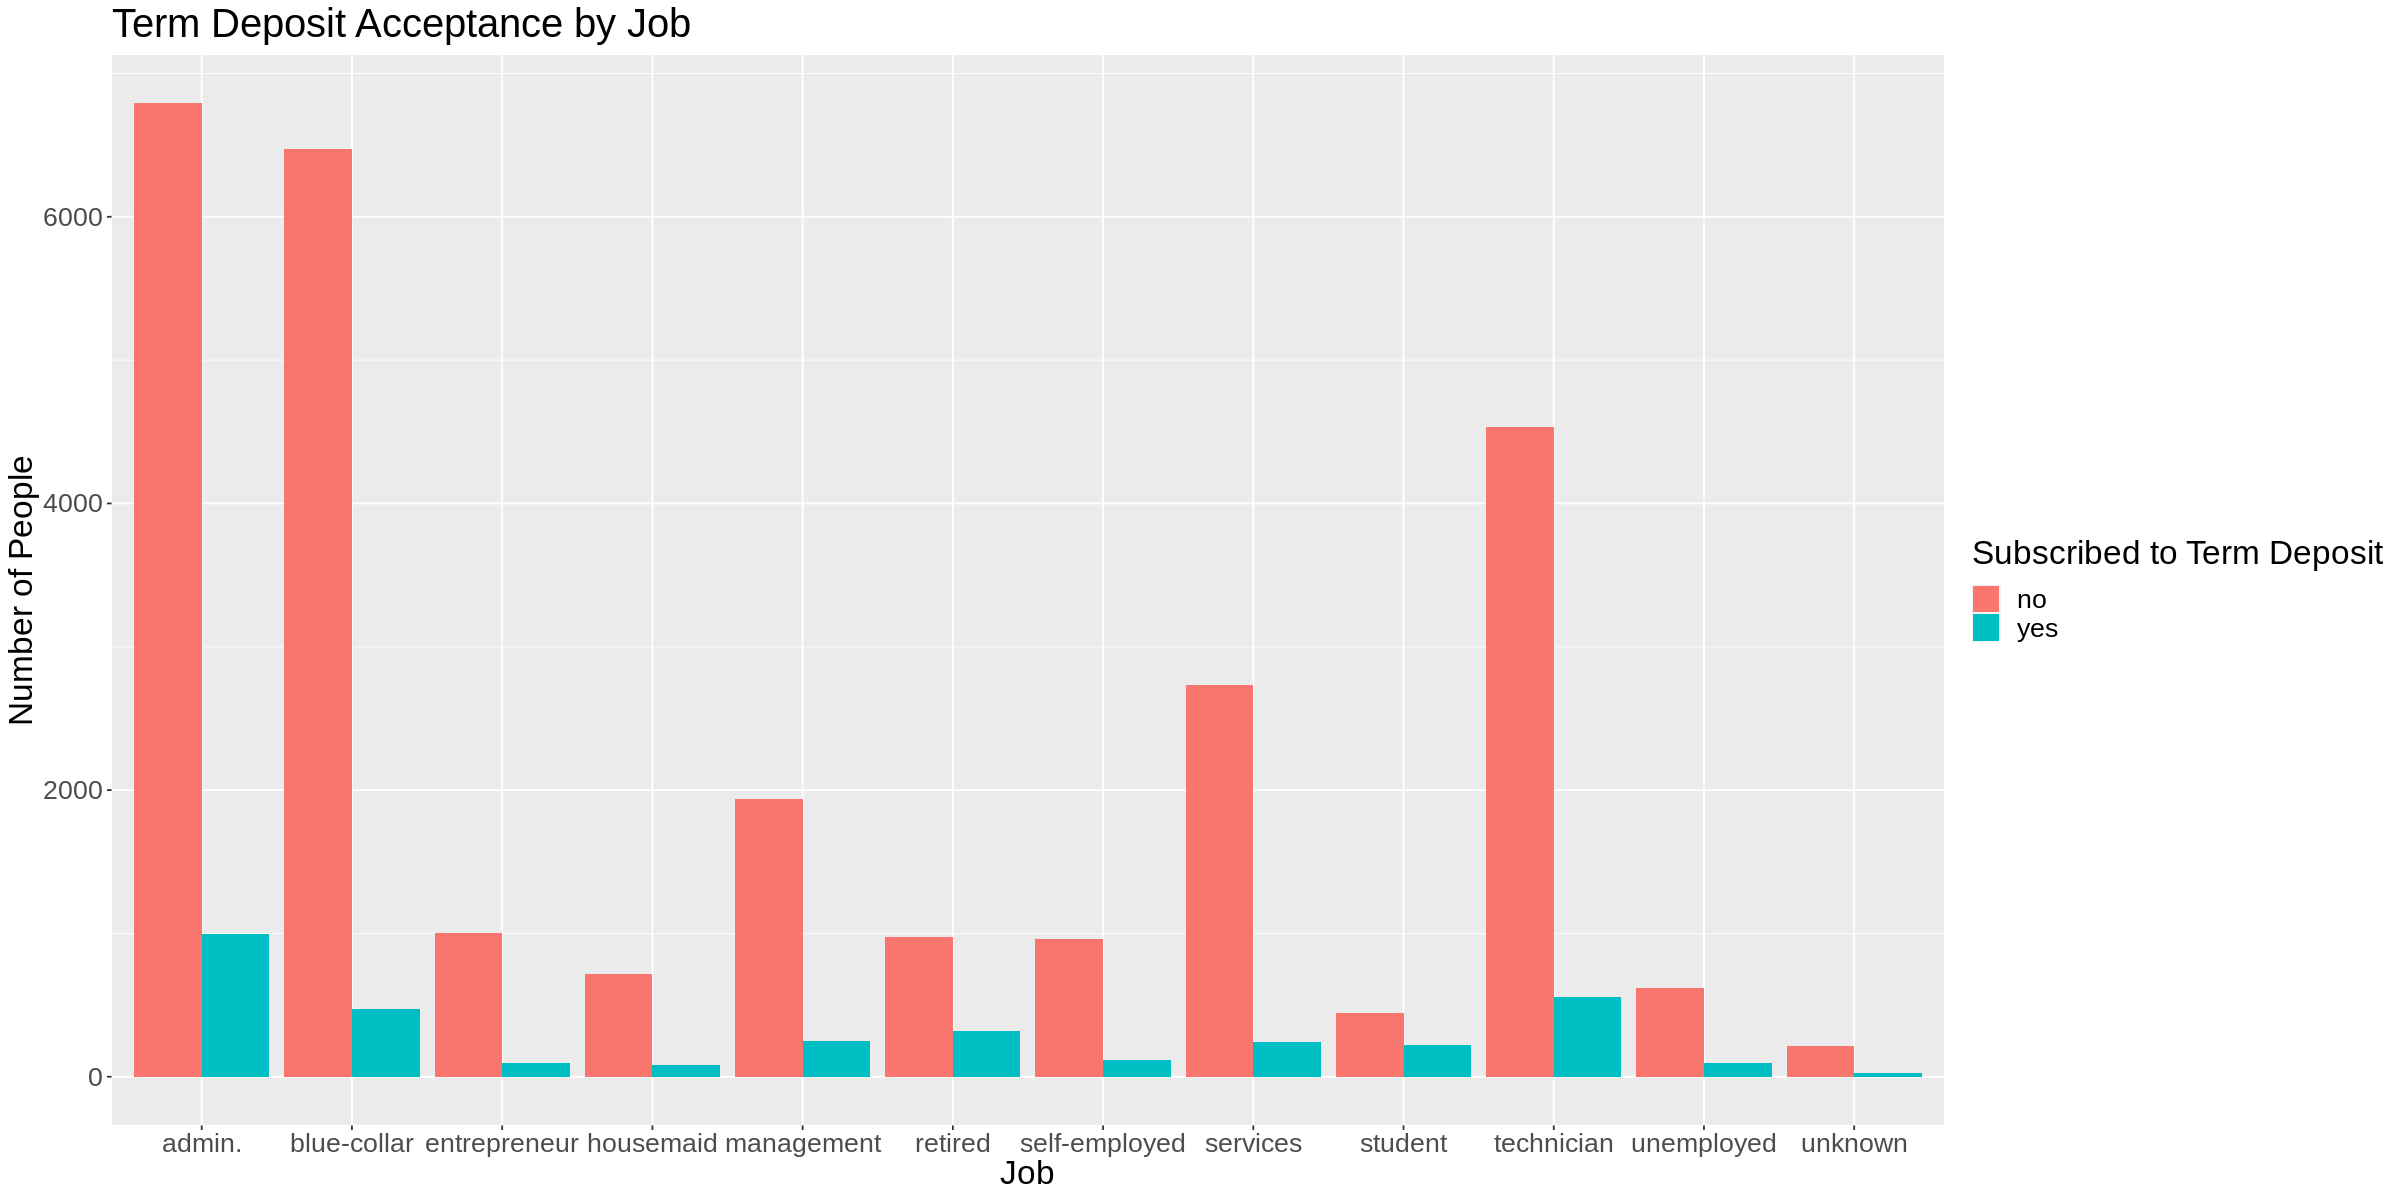

`summarise()` regrouping output by 'campaign' (override with `.groups` argument)



campaign y   n    
1  1        no  11543
2  1        yes  1723
3  2        no   7067
4  2        yes   919
5  3        no   3520
⋮  ⋮        ⋮   ⋮    
53 40       no  2    
54 41       no  1    
55 42       no  2    
56 43       no  1    
57 56       no  1

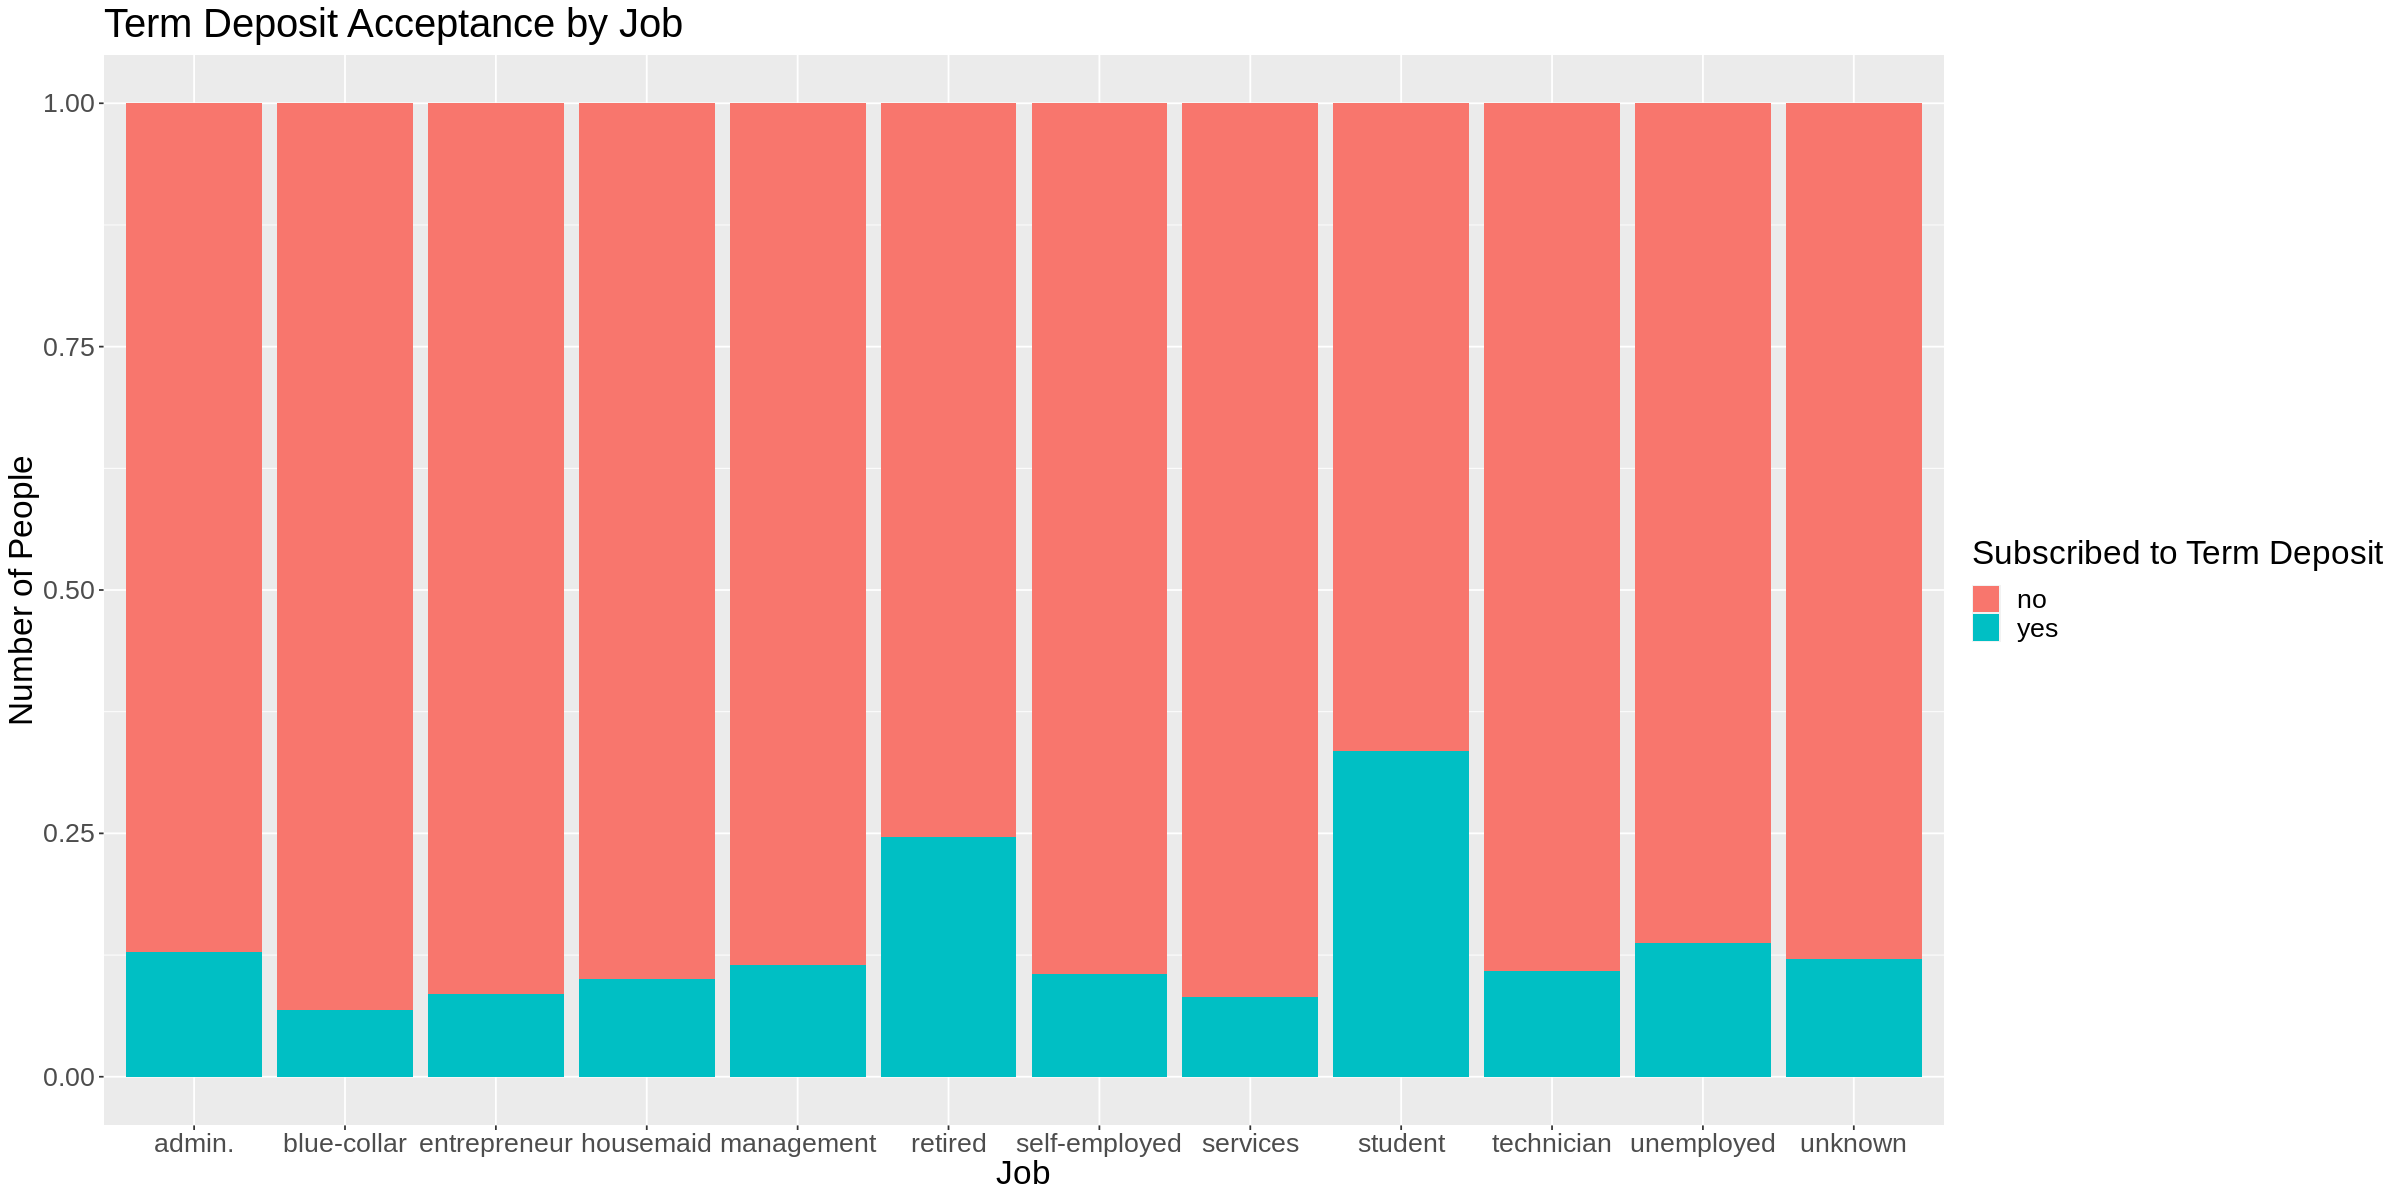

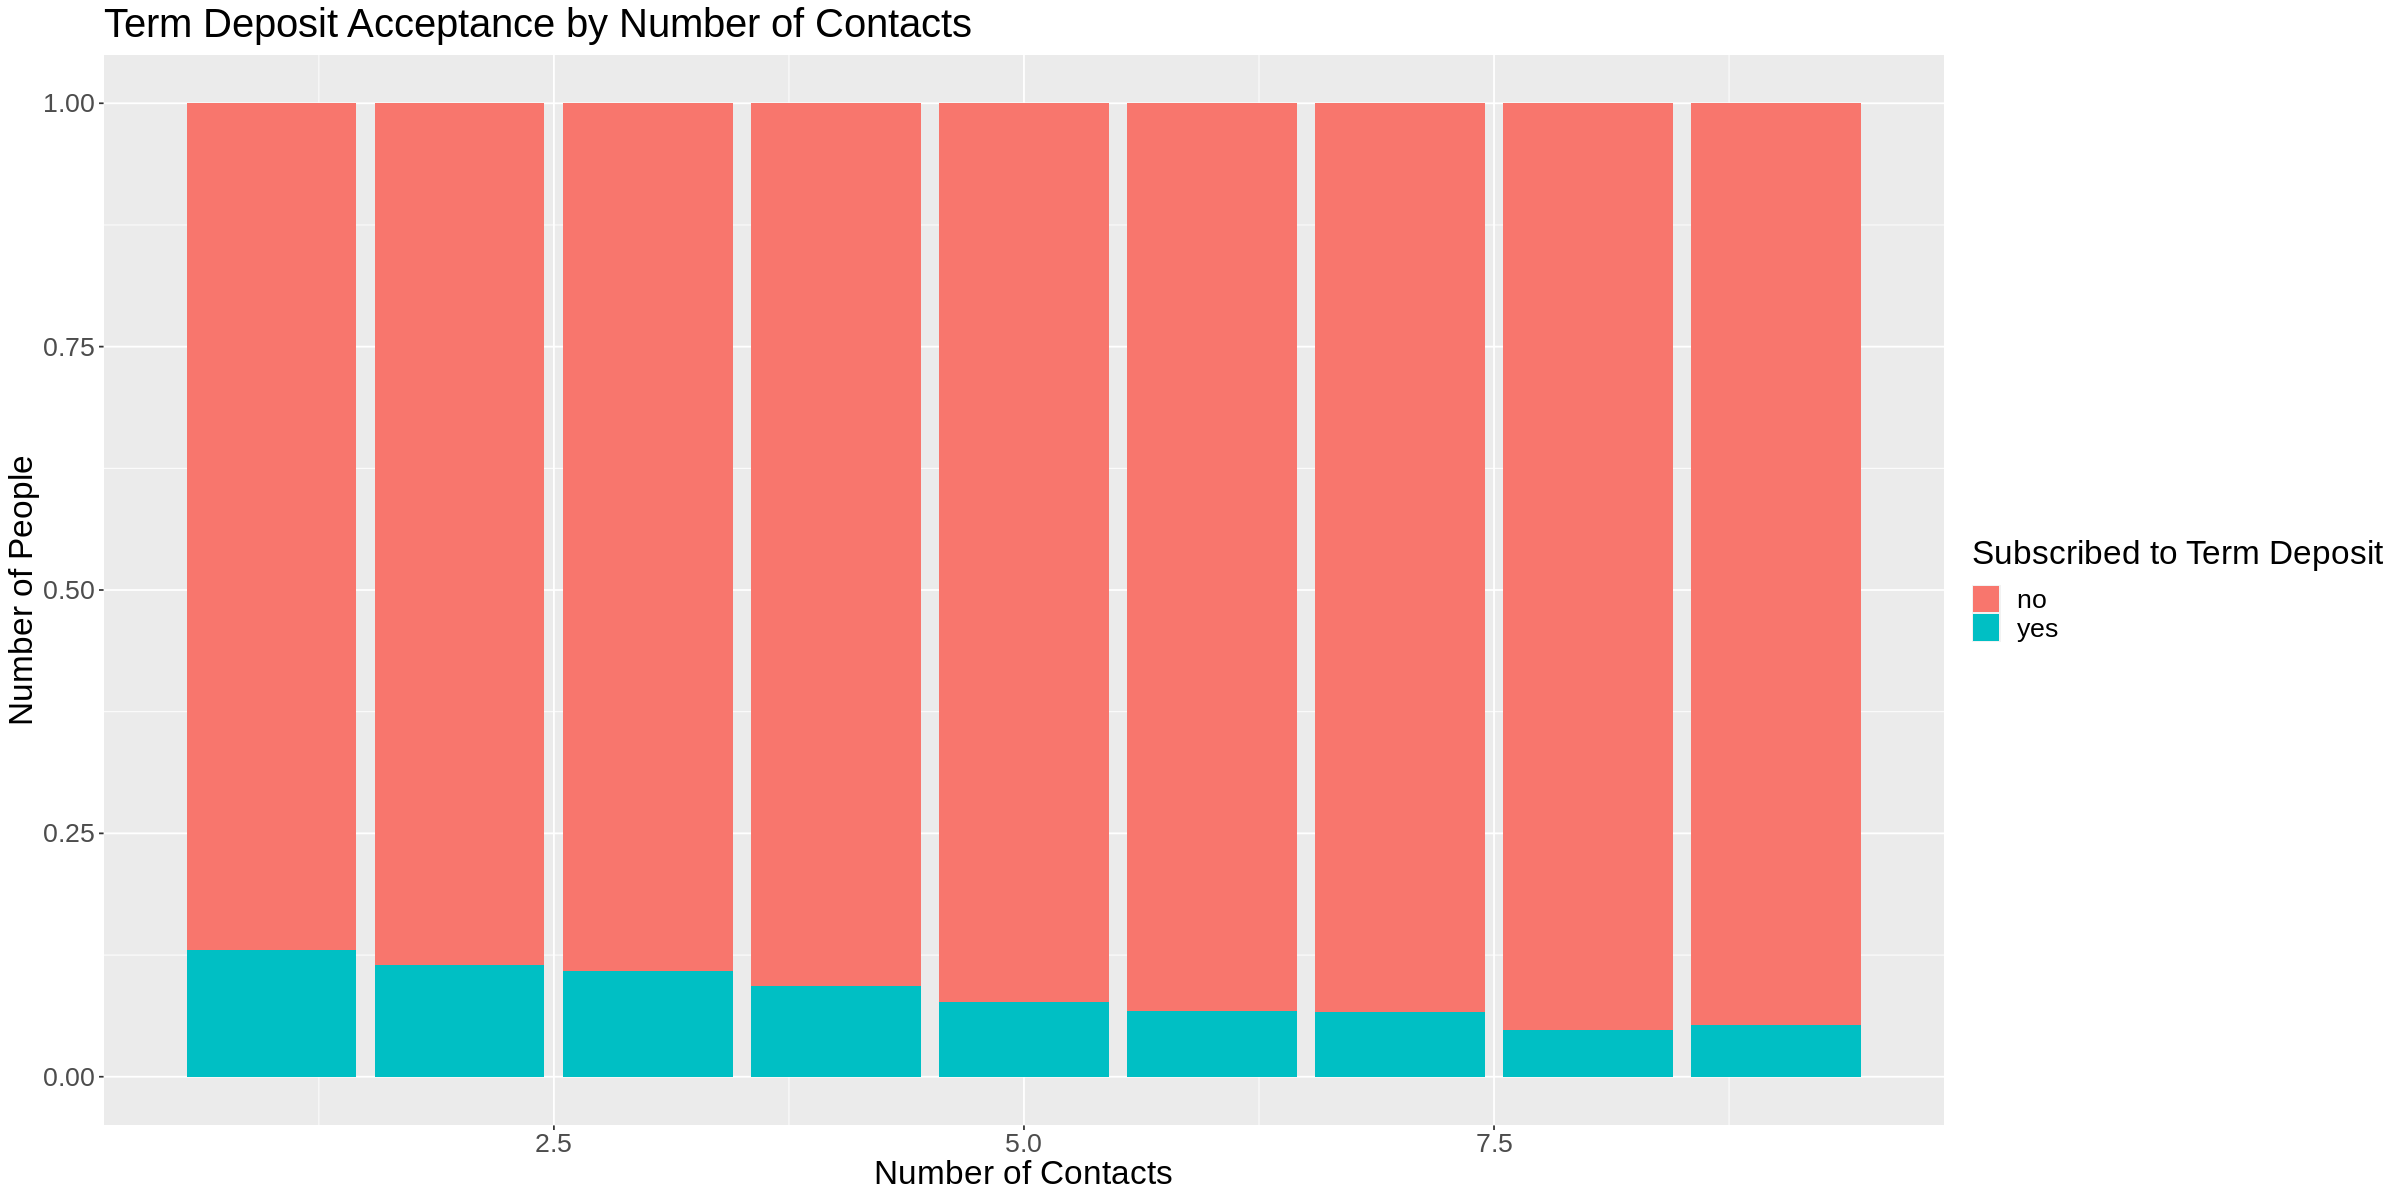

In [12]:
# Read the dataset and discard the unnecessary columns
bank_data <- read_delim("data/bank-additional-full.csv", delim=";") %>%
             select(age:day_of_week & !contact, campaign, y)

# Set the seed
set.seed(7134) 

# Randomly take 75% of the data in the training set. 
bank_split <- initial_split(bank_data, prop = 0.75, strata = y)  
bank_train <- training(bank_split)
bank_train

# Get mean, min, and max of age
age_summary <- bank_train %>%
               summarize(
                   min_age = min(age),
                   max_age = max(age),
                   mean_age = mean(age))
age_summary

# Get the mean, min, and max of age grouped by y
# Observe that splitting on y barely changes the min/max/mean,
# suggesting that age does not have a large affect on y
age_y_summary <- bank_train %>%
                 group_by(y) %>%
                 summarize(
                   min_age = min(age),
                   max_age = max(age),
                   mean_age = mean(age))
age_y_summary

# Get total number of people with each job grouped by y
job_groups <- bank_train %>%
              group_by(job, y) %>%
              summarize(n = n())
job_groups

# Plot job_groups
# We can see that students, retired, and admin have the highest proportion
# of people subscribing to a term deposit compared to not subscribing.
options(repr.plot.width = 20, repr.plot.height = 10) 
job_groups_plot1 <- ggplot(job_groups, aes(x = job, y = n, fill = y)) + 
    geom_bar(stat = "identity", position = "dodge") + 
   xlab("Job") +
   ylab("Number of People") +
   labs(fill = "Subscribed to Term Deposit") +
    theme(text = element_text(size = 20)) +
    ggtitle("Term Deposit Acceptance by Job")
job_groups_plot1

job_groups_plot2 <- ggplot(job_groups, aes(x = job, y = n, fill = y)) + 
    geom_bar(stat = "identity", position = "fill") + 
    xlab("Job") +
    ylab("Number of People") +
    labs(fill = "Subscribed to Term Deposit") +
    theme(text = element_text(size = 20)) +
    ggtitle("Term Deposit Acceptance by Job")
job_groups_plot2

# Get the total number of people grouped by number of times contacted,
# and whether or not they subscribed to a term deposit
num_contacts <- bank_train %>%
                     group_by(campaign, y) %>%
                     summarize(n = n())
num_contacts

# Plot num_contacts, filter to only include rows with < 10 contacts,
# since from the table above we can observe that n becomes negligible 
# above 10 contacts.
# We can see that as the number of contacts increases the
# proportion of people who accepted a term deposit decreases
num_contacts_plot <- num_contacts %>%
    filter(campaign < 10) %>%
    ggplot(aes(x = campaign, y = n, fill = y)) + 
    geom_bar(stat = "identity", position = "fill") + 
    xlab("Number of Contacts") +
    ylab("Number of People") +
    labs(fill = "Subscribed to Term Deposit") +
    theme(text = element_text(size = 20)) +
    ggtitle("Term Deposit Acceptance by Number of Contacts")
num_contacts_plot

<h2>Methods</h2>
<h3>Data Analysis:</h3>
1) Clean and wrangle data into a tidy format<br />
2) Select for variables of use (10) and create a table<br />
3) Group data to help determine if there is a statistical relationship for our categorical response<br />
4) Plot and visualize grouped data<br />
5) Identify patterns and connections in the data.<br />
We selected 10 variables of the data set as they will provide the most evidence for a classification relationship that can be used to predict if the client will subscribe. Also in our analysis, we will randomly select 75% of the data for our training set (the remaining 25% will be our test set). 

<h3>Input Variables:</h3>
1 - age <br />
2 - Job<br />
3 - marital status<br />
4 - education <br />
5 - Has credit in default? <br />
6 - Housing: has housing loan? <br />
7 - loan: has personal loan? <br />
8 - month: last contact month of year <br />
9 - day of week  <br />
10 - campaign: # of contacts during the campaign <br />

<h3>Visualizing the Data:</h3>
We are aiming to make a bar plot to visualize comparisons of amounts of the output variable (“Yes” or “No”). We will have a legend where the categorical variable “Yes” will be one colour and “No” will be a different colour. The y-axis will be the amount and x-axis will be our grouped input variable.

<h2>Expected Outcomes and Significance</h2>
    After conducting data analysis on the bank marketing data set, we expect to find how different variables affect the probability of customers subscribing to a term deposit. 
    
We will build a predictive model using 10 of the variables to predict whether a client subscribes to a term deposit or not. These findings are crucial as it can significantly improve the bank's financial performance through the increase in sales revenue. Bank managers have higher possibilities to generate sales as they can identify potential customers and filter out the challenging ones through the dataset result. 

Multiple questions can be derived from this dataset analysis. For example, which variables impact the customer's willingness to subscribe to a term deposit, or if these predictions could be used to identify relations with other bank products as well

<h2>References</h2>
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014